# Food Wastage Management System

**Introduction :**

Food wastage is a growing concern worldwide, affecting both the environment and communities in need. Many organizations and individuals donate surplus food, but tracking, analyzing, and optimizing this process is often challenging.

The Food Wastage Dashboard project was developed to provide a centralized, interactive platform that captures data from food providers, receivers, and claims. By integrating data cleaning, database management, analysis, and visualization, the system helps stakeholders monitor donation trends, identify high-performing locations, and address areas with low food distribution.

Built using Python, SQLite, Matplotlib/Seaborn, and Streamlit, the dashboard offers real-time insights into food donations, enabling better decision-making to reduce waste and improve distribution efficiency.

## Data Preparation

Loaded the raw CSV files (providers_data.csv, receivers_data.csv, food_listings_data.csv, claims_data.csv).

Removed duplicates to avoid double counting.

Handled missing values (NaN) in key columns like city, provider name, and food details.

Standardized column names and formats (e.g., consistent casing, removing spaces).

Saved the cleaned data into a cleaned_data folder as:

providers_clean.csv

receivers_clean.csv

food_listings_clean.csv

claims_clean.csv

In [118]:
import pandas as pd

In [119]:
# Load datasets
providers = pd.read_csv('/content/providers_data.csv')
receivers = pd.read_csv('/content/receivers_data.csv')
food_listings = pd.read_csv('/content/food_listings_data.csv')
claims = pd.read_csv('/content/claims_data.csv')

In [120]:
# Preview first few rows of each dataset
providers_head = providers.head()
receivers_head = receivers.head()
food_listings_head = food_listings.head()
claims_head = claims.head()

providers_head, receivers_head, food_listings_head, claims_head

(   Provider_ID                         Name           Type  \
 0            1             Gonzales-Cochran    Supermarket   
 1            2  Nielsen, Johnson and Fuller  Grocery Store   
 2            3                 Miller-Black    Supermarket   
 3            4   Clark, Prince and Williams  Grocery Store   
 4            5               Coleman-Farley  Grocery Store   
 
                                              Address            City  \
 0  74347 Christopher Extensions\nAndreamouth, OK ...     New Jessica   
 1           91228 Hanson Stream\nWelchtown, OR 27136     East Sheena   
 2  561 Martinez Point Suite 507\nGuzmanchester, W...  Lake Jesusview   
 3     467 Bell Trail Suite 409\nPort Jesus, IA 61188     Mendezmouth   
 4  078 Matthew Creek Apt. 319\nSaraborough, MA 53978   Valentineside   
 
                 Contact  
 0       +1-600-220-0480  
 1  +1-925-283-8901x6297  
 2      001-517-295-2206  
 3      556.944.8935x401  
 4          193.714.6577  ,
    Receiver_ID  

**Clean the Data**

In [121]:
# Convert date columns
food_listings['Expiry_Date'] = pd.to_datetime(food_listings['Expiry_Date'], errors='coerce').dt.date
claims['Timestamp'] = pd.to_datetime(claims['Timestamp'], errors='coerce')

In [122]:
# Remove duplicates
providers.drop_duplicates(inplace=True)
receivers.drop_duplicates(inplace=True)
food_listings.drop_duplicates(inplace=True)
claims.drop_duplicates(inplace=True)

In [123]:
# Standardize text columns (strip spaces)
def strip_text_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # only text columns
            df[col] = df[col].astype(str).str.strip()
    return df

providers = strip_text_columns(providers)
receivers = strip_text_columns(receivers)
food_listings = strip_text_columns(food_listings)
claims = strip_text_columns(claims)

In [124]:
# Validate ID columns (ensure integer type and unique for primary keys)
providers['Provider_ID'] = providers['Provider_ID'].astype(int)
receivers['Receiver_ID'] = receivers['Receiver_ID'].astype(int)
food_listings['Food_ID'] = food_listings['Food_ID'].astype(int)
claims['Claim_ID'] = claims['Claim_ID'].astype(int)

In [125]:
# Check uniqueness for primary keys
unique_ids = {
    "Providers": providers['Provider_ID'].is_unique,
    "Receivers": receivers['Receiver_ID'].is_unique,
    "Food_Listings": food_listings['Food_ID'].is_unique,
    "Claims": claims['Claim_ID'].is_unique
}

In [126]:
# Save in the cleaned_data folder
providers.to_csv("/content/providers_clean.csv", index=False)
receivers.to_csv("/content/receivers_clean.csv", index=False)
food_listings.to_csv("/content/food_listings_clean.csv", index=False)
claims.to_csv("/content/claims_clean.csv", index=False)

## SQL Database Creation

Created an SQLite database.

**Designed tables:**

Providers

Receivers

Food_Listings

Claims

Defined relationships (e.g., Providers → Food Listings → Claims).

Imported cleaned CSVs into the database using pandas.to_sql().

In [70]:
import os
import sqlite3
import pandas as pd

# 1. Remove old database file if it exists
if os.path.exists("food_wastage.db"):
    os.remove("food_wastage.db")

# 2. Connect to new database
conn = sqlite3.connect("food_wastage.db")
cursor = conn.cursor(
)

In [71]:
# 3. Create tables
cursor.executescript("""
CREATE TABLE Providers (
    Provider_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    Address TEXT,
    City TEXT,
    Contact TEXT
);

CREATE TABLE Receivers (
    Receiver_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    City TEXT,
    Contact TEXT
);

CREATE TABLE Food_Listings (
    Food_ID INTEGER PRIMARY KEY,
    Food_Name TEXT,
    Quantity INTEGER,
    Expiry_Date DATE,
    Provider_ID INTEGER,
    Provider_Type TEXT,
    Location TEXT,
    Food_Type TEXT,
    Meal_Type TEXT,
    FOREIGN KEY (Provider_ID) REFERENCES Providers(Provider_ID)
);

CREATE TABLE Claims (
    Claim_ID INTEGER PRIMARY KEY,
    Food_ID INTEGER,
    Receiver_ID INTEGER,
    Status TEXT,
    Timestamp DATETIME,
    FOREIGN KEY (Food_ID) REFERENCES Food_Listings(Food_ID),
    FOREIGN KEY (Receiver_ID) REFERENCES Receivers(Receiver_ID)
);
""")


In [72]:
# 4. Load cleaned CSVs
providers = pd.read_csv("/content/providers_clean.csv")
receivers = pd.read_csv("/content/receivers_clean.csv")
food_listings = pd.read_csv("/content/food_listings_clean.csv")
claims = pd.read_csv("/content/claims_clean.csv")

In [73]:
# 5. Insert data into tables (replace to avoid duplication)
providers.to_sql("Providers", conn, if_exists="append", index=False)
receivers.to_sql("Receivers", conn, if_exists="append", index=False)
food_listings.to_sql("Food_Listings", conn, if_exists="append", index=False)
claims.to_sql("Claims", conn, if_exists="append", index=False)

# 6. Commit & close connection
conn.commit()
conn.close()

print("✅ Database created and data loaded successfully!")

✅ Database created and data loaded successfully!


## SQL Queries

Wrote SQL queries to answer key questions, such as:

Top cities with the most providers/receivers.

Total amount of food donated per city.

Most claimed food items.

Monthly trend of donations.

Used Python with sqlite3 + pandas to fetch and analyze the data.


In [74]:
import sqlite3
import pandas as pd


In [75]:
# Connect to DB
conn = sqlite3.connect('food_wastage.db')

In [76]:
# 1. How many food providers and receivers are there in each city?
q1 = """
SELECT City,
       COUNT(DISTINCT Provider_ID) AS Total_Providers,
       COUNT(DISTINCT Receiver_ID) AS Total_Receivers
FROM (
    SELECT City, Provider_ID, NULL as Receiver_ID FROM Providers
    UNION ALL
    SELECT City, NULL, Receiver_ID FROM Receivers
) AS combined
GROUP BY City;
"""

In [77]:
# 2. Which type of food provider contributes the most food?
q2 = """
SELECT Provider_Type, SUM(Quantity) AS Total_Quantity
FROM Food_Listings
GROUP BY Provider_Type
ORDER BY Total_Quantity DESC;
"""

In [78]:
# 3. Contact info of food providers in a specific city (example: 'New York')
q3 = """
SELECT Name, Contact
FROM Providers
WHERE City = 'New York';
"""

In [79]:
# 4. Which receivers have claimed the most food?
q4 = """
SELECT r.Name, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Receivers r ON c.Receiver_ID = r.Receiver_ID
GROUP BY r.Name
ORDER BY Total_Claims DESC;
"""

In [80]:
# 5. Total quantity of food available
q5 = "SELECT SUM(Quantity) AS Total_Food_Quantity FROM Food_Listings;"


In [81]:
# 6. City with the highest number of food listings
q6 = """
SELECT Location AS City, COUNT(*) AS Total_Listings
FROM Food_Listings
GROUP BY Location
ORDER BY Total_Listings DESC
LIMIT 1;
"""

In [82]:
# 7. Most commonly available food types
q7 = """
SELECT Food_Type, COUNT(*) AS Count_Type
FROM Food_Listings
GROUP BY Food_Type
ORDER BY Count_Type DESC;
"""

In [83]:
# 8. How many food claims have been made for each food item?
q8 = """
SELECT f.Food_Name, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
GROUP BY f.Food_Name
ORDER BY Total_Claims DESC;
"""

In [84]:
# 9. Provider with the highest number of successful food claims
q9 = """
SELECT p.Name, COUNT(c.Claim_ID) AS Successful_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
JOIN Providers p ON f.Provider_ID = p.Provider_ID
WHERE c.Status = 'Completed'
GROUP BY p.Name
ORDER BY Successful_Claims DESC
LIMIT 1;
"""


In [85]:
# 10. Percentage of claims by status
q10 = """
SELECT Status,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Claims), 2) AS Percentage
FROM Claims
GROUP BY Status;
"""

In [86]:
# 11. Average quantity of food claimed per receiver
q11 = """
SELECT r.Name, ROUND(AVG(f.Quantity), 2) AS Avg_Quantity_Claimed
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
JOIN Receivers r ON c.Receiver_ID = r.Receiver_ID
GROUP BY r.Name;
"""

In [87]:
# 12. Which meal type is claimed the most?
q12 = """
SELECT f.Meal_Type, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
GROUP BY f.Meal_Type
ORDER BY Total_Claims DESC;
"""

In [88]:
# 13. Total quantity donated by each provider
q13 = """
SELECT p.Name, SUM(f.Quantity) AS Total_Donated
FROM Food_Listings f
JOIN Providers p ON f.Provider_ID = p.Provider_ID
GROUP BY p.Name
ORDER BY Total_Donated DESC;
"""

In [89]:
# 14. Food items expiring within 7 days
q14 = """
SELECT Food_Name, Expiry_Date
FROM Food_Listings
WHERE julianday(Expiry_Date) - julianday('now') <= 7;
"""

In [90]:
# 15. High-demand food types (most claims)
q15 = """
SELECT f.Food_Type, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
GROUP BY f.Food_Type
ORDER BY Total_Claims DESC;
"""

queries = [q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15]

In [91]:
# Run and display each query
for i, query in enumerate(queries, start=1):
    print(f"\n--- Query {i} ---")
    df = pd.read_sql(query, conn)
    print(df.head())

conn.close()


--- Query 1 ---
         City  Total_Providers  Total_Receivers
0  Aaronshire                0                1
1    Adambury                1                0
2    Adamland                0                1
3   Adamsview                1                0
4  Adamsville                1                0

--- Query 2 ---
      Provider_Type  Total_Quantity
0        Restaurant            6923
1       Supermarket            6696
2  Catering Service            6116
3     Grocery Store            6059

--- Query 3 ---
Empty DataFrame
Columns: [Name, Contact]
Index: []

--- Query 4 ---
                Name  Total_Claims
0  William Frederick             5
1       Scott Hunter             5
2       Matthew Webb             5
3     Anthony Garcia             5
4    Kristine Martin             4

--- Query 5 ---
   Total_Food_Quantity
0                25794

--- Query 6 ---
            City  Total_Listings
0  South Kathryn               6

--- Query 7 ---
        Food_Type  Count_Type
0      Veg

## Exploratory Data Analysis & Visualizations

Used Matplotlib and Seaborn for visualizations.

Created bar charts, pie charts, and trend lines for:

Providers by city.

Food donation trends over time.

Claims distribution.

Fixed issues like missing city names in charts by merging datasets.

In [92]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# Connect to database
conn = sqlite3.connect('food_wastage.db')


In [94]:
# Example assuming 'providers' dataframe is loaded
df_city = providers.groupby("City", as_index=False).size().rename(columns={"size": "Providers_Count"})

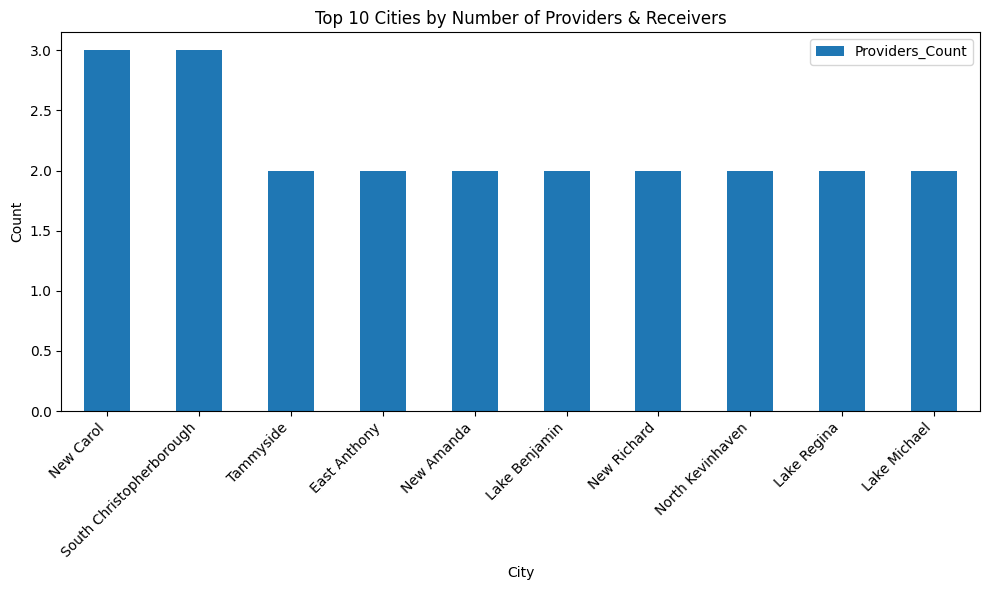

In [95]:
# 1. Show only top 10 cities by Providers_Count
df_city_top = df_city.sort_values("Providers_Count", ascending=False).head(10)

# Plot
df_city_top.plot(
    x="City",
    kind="bar",
    stacked=False,
    figsize=(10,6),
    color=["#1f77b4", "#ff7f0e"]  # Blue and orange bars
)

plt.title("Top 10 Cities by Number of Providers & Receivers")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate labels and align to the right
plt.tight_layout()
plt.show()


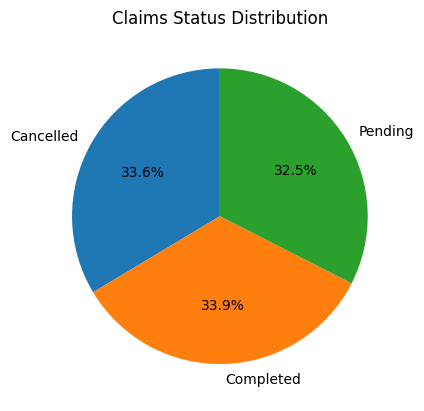

In [96]:
# 2. Claim status distribution
df_claims_status = pd.read_sql("""
SELECT Status, COUNT(*) AS Count
FROM Claims
GROUP BY Status;
""", conn)

plt.pie(df_claims_status["Count"], labels=df_claims_status["Status"], autopct="%1.1f%%", startangle=90)
plt.title("Claims Status Distribution")
plt.show()

/tmp/ipython-input-2310876724.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_providers, x="Total_Donated", y="Name", palette="viridis")


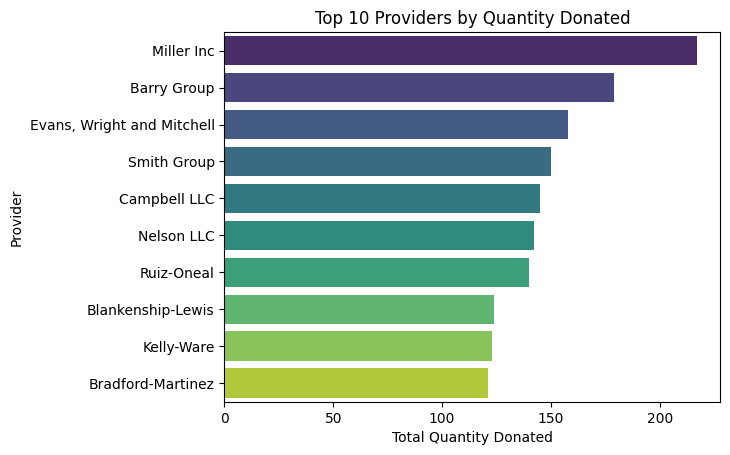

In [97]:
# 3. Top 10 providers by total quantity donated
df_top_providers = pd.read_sql("""
SELECT p.Name, SUM(f.Quantity) AS Total_Donated
FROM Food_Listings f
JOIN Providers p ON f.Provider_ID = p.Provider_ID
GROUP BY p.Name
ORDER BY Total_Donated DESC
LIMIT 10;
""", conn)

sns.barplot(data=df_top_providers, x="Total_Donated", y="Name", palette="viridis")
plt.title("Top 10 Providers by Quantity Donated")
plt.xlabel("Total Quantity Donated")
plt.ylabel("Provider")
plt.show()

/tmp/ipython-input-3092520079.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_meal_claims, x="Meal_Type", y="Total_Claims", palette="Set2")


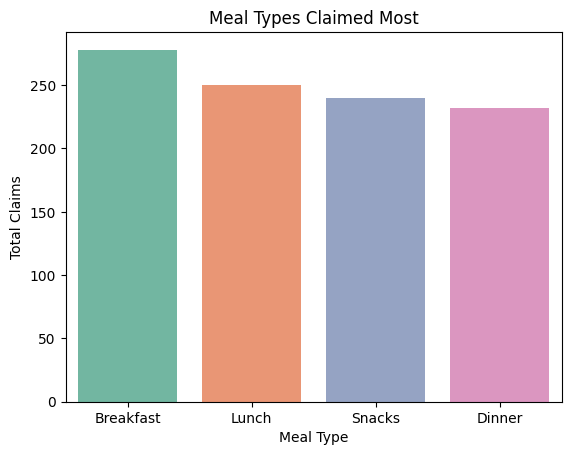

In [98]:
# 4. Meal types claimed most
df_meal_claims = pd.read_sql("""
SELECT f.Meal_Type, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
GROUP BY f.Meal_Type
ORDER BY Total_Claims DESC;
""", conn)

sns.barplot(data=df_meal_claims, x="Meal_Type", y="Total_Claims", palette="Set2")
plt.title("Meal Types Claimed Most")
plt.xlabel("Meal Type")
plt.ylabel("Total Claims")
plt.show()


/tmp/ipython-input-3803287654.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_foodtype_claims, x="Food_Type", y="Total_Claims", palette="coolwarm")


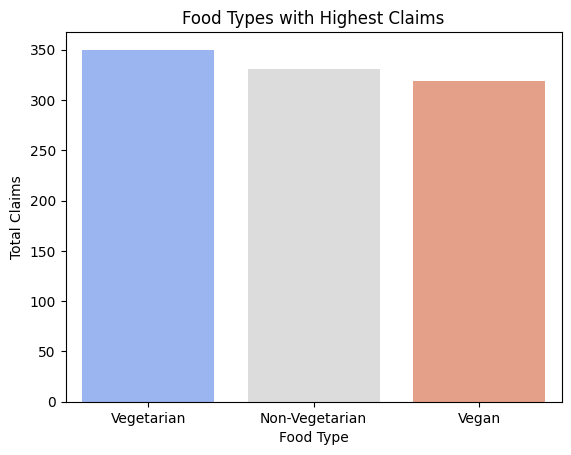

In [99]:
# 5. Food types with highest claims
df_foodtype_claims = pd.read_sql("""
SELECT f.Food_Type, COUNT(c.Claim_ID) AS Total_Claims
FROM Claims c
JOIN Food_Listings f ON c.Food_ID = f.Food_ID
GROUP BY f.Food_Type
ORDER BY Total_Claims DESC;
""", conn)

sns.barplot(data=df_foodtype_claims, x="Food_Type", y="Total_Claims", palette="coolwarm")
plt.title("Food Types with Highest Claims")
plt.xlabel("Food Type")
plt.ylabel("Total Claims")
plt.show()

In [100]:
conn.close()

## Streamlit App Development

Developed app.py using Streamlit.

Added sidebar filters for city, date range, and food type.

Integrated charts from Phase 4 into an interactive UI.

Ran the app locally and on Google Colab using Ngrok to get a public link.

In [127]:
from google.colab import files

# Upload app.py
files.upload()

Saving app.py to app (4).py


{'app (4).py': b'import streamlit as st\r\nimport pandas as pd\r\n\r\n@st.cache_data\r\ndef load_data():\r\n    providers = pd.read_csv("cleaned_data/providers_clean.csv")\r\n    receivers = pd.read_csv("cleaned_data/receivers_clean.csv")\r\n    food_listings = pd.read_csv("cleaned_data/food_listings_clean.csv")\r\n    claims = pd.read_csv("cleaned_data/claims_clean.csv")\r\n    return providers, receivers, food_listings, claims\r\n\r\nst.title("Food Wastage Dashboard")\r\n\r\nproviders, receivers, food_listings, claims = load_data()\r\n\r\nst.subheader("Providers Data")\r\nst.dataframe(providers)\r\n\r\nst.subheader("Receivers Data")\r\nst.dataframe(receivers)\r\n'}

In [128]:
import os

# Make cleaned_data folder
os.makedirs("cleaned_data", exist_ok=True)


In [129]:
from google.colab import files

# Upload CSVs to cleaned_data folder
uploaded = files.upload()
for fname in uploaded.keys():
    os.rename(fname, f"cleaned_data/{fname}")


Saving claims_clean.csv to claims_clean (2).csv
Saving food_listings_clean.csv to food_listings_clean (2).csv
Saving providers_clean.csv to providers_clean (2).csv
Saving receivers_clean.csv to receivers_clean (2).csv


In [130]:
!pip install streamlit pyngrok


In [131]:
!ngrok config add-authtoken 31B0Y4qi9DQ05hUtxgstwcYVjjc_6tv1xQkwVqyQifYxjga2y

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [132]:
from pyngrok import ngrok
import threading
import time
import os

# Function to run Streamlit in a thread
def run_streamlit():
    os.system("streamlit run app.py --server.port 8501 --server.headless true")

# Start streamlit in background
threading.Thread(target=run_streamlit).start()

# Wait a bit for server to start
time.sleep(5)

# Start ngrok tunnel
public_url = ngrok.connect(8501)
print("Streamlit app is live at:", public_url)


Streamlit app is live at: NgrokTunnel: "https://a5d42c235748.ngrok-free.app" -> "http://localhost:8501"


## **Conclusion :**

The Food Wastage Dashboard successfully transforms raw food donation data into meaningful, interactive insights. From data preparation to visualization, the project demonstrates how analytics can play a key role in addressing food wastage challenges.

By providing real-time statistics on donations, claims, and provider activity, the dashboard empowers NGOs, food banks, and government agencies to make data-driven decisions. Moreover, its interactive filters allow users to explore trends across cities, time periods, and food types.

While this version provides strong analytical capabilities, future enhancements could include predictive analytics, real-time IoT integration for tracking food freshness, and automated alert systems to further improve food rescue efforts.

In essence, this project is not just a data visualization tool—it’s a step toward reducing food wastage and promoting sustainable resource use.